In [ ]:
drive.flush_and_unmount()

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
path_basic = 'drive/My Drive/face-swap'
os.chdir(path_basic)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid');

In [ ]:
import pandas as pd
import numpy as np

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [ ]:
def sit_to_dict(summary_iterators, tags, default_tag='Loss/G'):
  tag_values = defaultdict(list)

  for i in range(len(summary_iterators)):
    if i == len(summary_iterators) - 1:
      steps_now = [e.step for e in summary_iterators[i].Scalars(default_tag)]
      for tag in tags:
        try:
          event_tag = summary_iterators[i].Scalars(tag)
        except:
          continue
        values_now = [(e.step,e.value) for e in event_tag]
        tag_values[tag].extend(values_now)

      print(f"S-{i}: first:last step - {steps_now[0]}:{steps_now[-1]} - {len(steps_now)}")
    else:
      steps_now = [e.step for e in summary_iterators[i].Scalars(default_tag)]
      steps_next = [e.step for e in summary_iterators[i+1].Scalars(default_tag)]
      start = min(steps_now)
      stop = min(steps_next)
      if start - stop == 0:
        continue

      for tag in tags:
        try:
          event_tag = summary_iterators[i].Scalars(tag)
        except:
          continue
        values_now = [(e.step,e.value) for e in event_tag if e.step <= stop]
        tag_values[tag].extend(values_now)
      print(f"S-{i}: first:last step - {start}:{stop} - {len(steps_now)}")

    

  return tag_values

In [ ]:
def get_sit(path):
  summary_iterators = [EventAccumulator(os.path.join(path, dname)).Reload() 
                    for dname in os.listdir(path)]
  summary_iterators = [s for s in summary_iterators if len(s.Tags()['scalars']) > 0]
  return summary_iterators


def get_csv(dict_object, tag):

  values = dict_object[tag]
  steps = [s[0] for s in values]
  values = [v[1] for v in values]

  df = pd.DataFrame(columns=['index', 'values'])
  df['index'] = steps
  df['values'] = values
  df = df.set_index('index')
  return df

In [ ]:
def get_results_dict(path, stop_it):
  summary_iterator = get_sit(path)
  # tags = summary_iterator[0].Tags()['scalars']
  tags = set()
  for s in summary_iterator:
    tags = tags.union(set(s.Tags()['scalars']))
  tags = list(tags)
  tag_values = sit_to_dict(summary_iterator, tags)

  results = {}
  for tag in tags:
    df_values = get_csv(tag_values, tag)
    df_values = df_values[df_values.index < stop_it].copy()
    results[tag] = df_values.copy()

  return results

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir='info/summary/SN_D_LS_vggface_heavy_idt_0.1_rec_50_att_100/1/'

In [ ]:
%tensorboard --logdir='info/summary/SN_D_LS_vggface_heavier/1/'

In [ ]:
%tensorboard --logdir='info/summary/SN_D_LS_vggface_heavier/4/'

In [ ]:
os.listdir('info/summary/')

In [ ]:
PATH_010 = 'info/summary/SN_D_LS_vggface_heavy_idt_x0.2/1/'
PATH_011 = 'info/summary/SN_D_LS_vggface_heavy_idt_x0.2_rec_x2/1/'
PATH_012 = 'info/summary/SN_D_LS_heavy_idt_x0.2/1/'
PATH_013 = 'info/summary/SN_D_LS_vggface_heavy_idt_x0.2_rec_x2_att_x4/1/'

In [ ]:
STOP_IT = 1e6  # take all
print("100")
results_010 = get_results_dict(PATH_010, STOP_IT)

print("1")
results_011 = get_results_dict(PATH_011, STOP_IT)

print("0.5")
results_012 = get_results_dict(PATH_012, STOP_IT)

print("0.2")
results_013 = get_results_dict(PATH_013, STOP_IT)

# print("vggface")
# results_014 = get_results_dict(PATH_014, STOP_IT)

100
S-0: first:last step - 5:10005 - 2000
S-1: first:last step - 10005:13795 - 759
1
S-0: first:last step - 5:3210 - 819
S-1: first:last step - 3210:11800 - 1719
0.5
S-0: first:last step - 5:4455 - 891
0.2
S-1: first:last step - 5:2140 - 467
S-2: first:last step - 2140:4280 - 469
S-3: first:last step - 4280:9100 - 965


In [ ]:
tag_fid = 'FID'
df_spec_score_010 = results_010[tag_fid]
df_spec_score_011 = results_011[tag_fid]
df_spec_score_012 = results_012[tag_fid]
df_spec_score_013 = results_013[tag_fid]
# df_spec_score_014 = results_014[tag_fid]

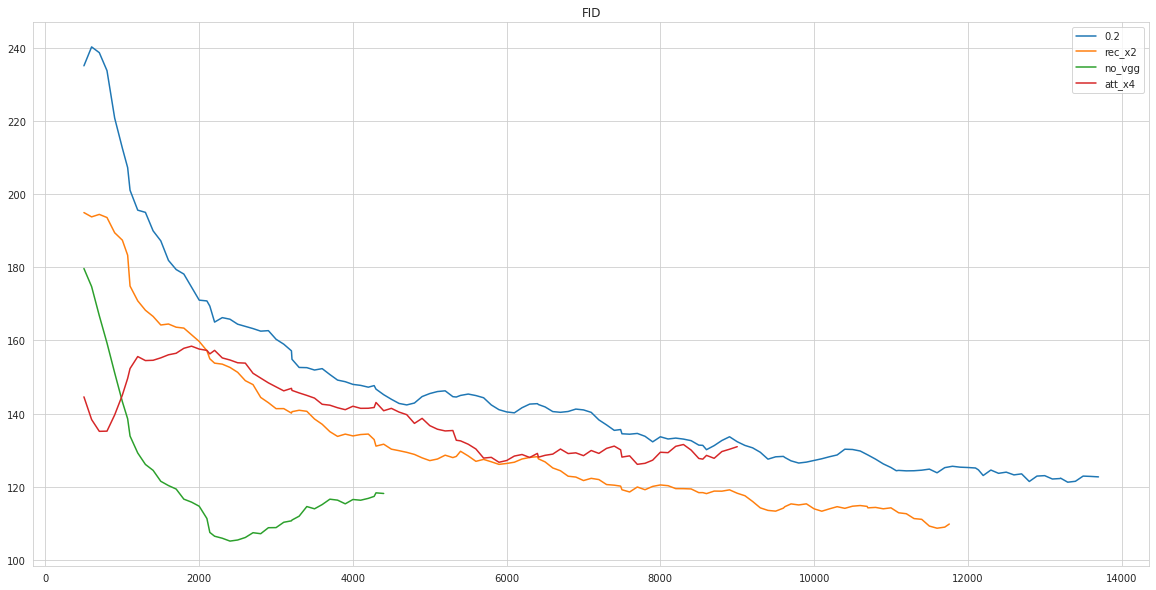

In [ ]:
rm=5
plt.subplots(figsize=(20,10))
plt.title("FID")
plt.plot(df_spec_score_010.rolling(rm).mean(), 
         label=f'0.2');
plt.plot(df_spec_score_011.rolling(rm).mean(), 
         label=f'rec_x2');
plt.plot(df_spec_score_012.rolling(rm).mean(), 
         label=f'no_vgg');
plt.plot(df_spec_score_013.rolling(rm).mean(), 
         label=f'att_x4')
# plt.plot(df_spec_score_014.rolling(rm).mean(), 
#          label=f'VGG');
plt.legend();

In [ ]:
tag_g = 'Loss/L_adv'
df_spec_g_010 = results_010[tag_g]
df_spec_g_011 = results_011[tag_g]
df_spec_g_012 = results_012[tag_g]
df_spec_g_013 = results_013[tag_g]

tag_d = 'Loss/D'
df_spec_d_010 = results_010[tag_d]
df_spec_d_011 = results_011[tag_d]
df_spec_d_012 = results_012[tag_d]
df_spec_d_013 = results_013[tag_d]

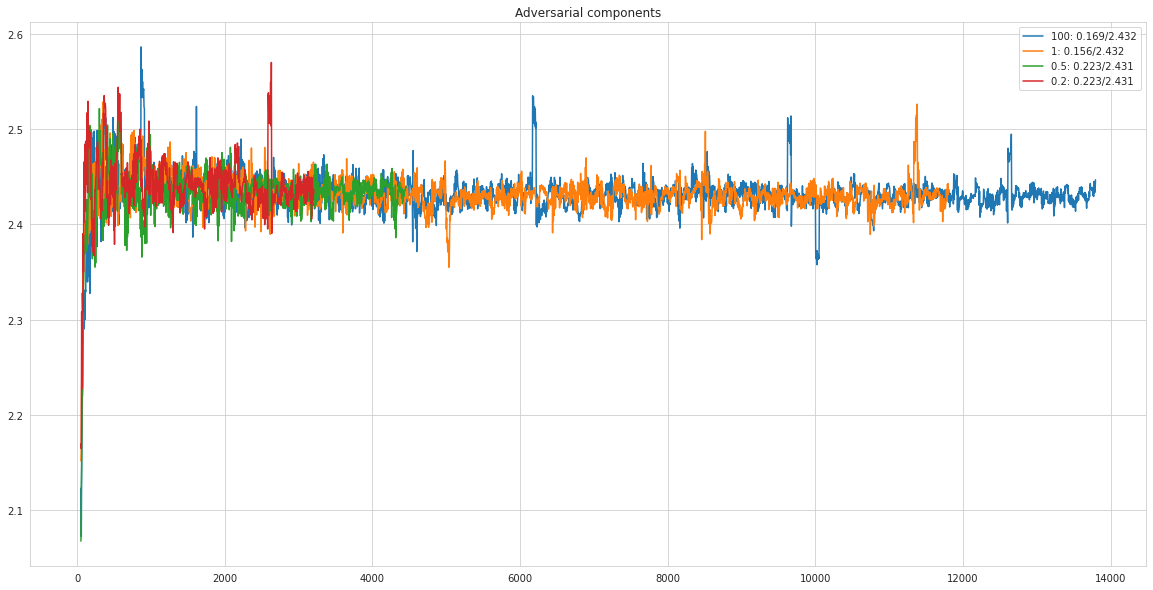

In [ ]:
rm = 10
plt.subplots(figsize=(20,10))
plt.title("Adversarial components")
plt.plot(df_spec_g_010.rolling(rm).mean(), 
         label=f'100: {df_spec_g_010.std()[0]:.3f}/{df_spec_g_010.mean()[0]:.3f}');
plt.plot(df_spec_g_011.rolling(rm).mean(), 
         label=f'1: {df_spec_g_011.std()[0]:.3f}/{df_spec_g_011.mean()[0]:.3f}');
plt.plot(df_spec_g_012.rolling(rm).mean(), 
         label=f'0.5: {df_spec_g_012.std()[0]:.3f}/{df_spec_g_012.mean()[0]:.3f}');
plt.plot(df_spec_g_013.rolling(rm).mean(), 
         label=f'0.2: {df_spec_g_012.std()[0]:.3f}/{df_spec_g_012.mean()[0]:.3f}');

plt.legend();

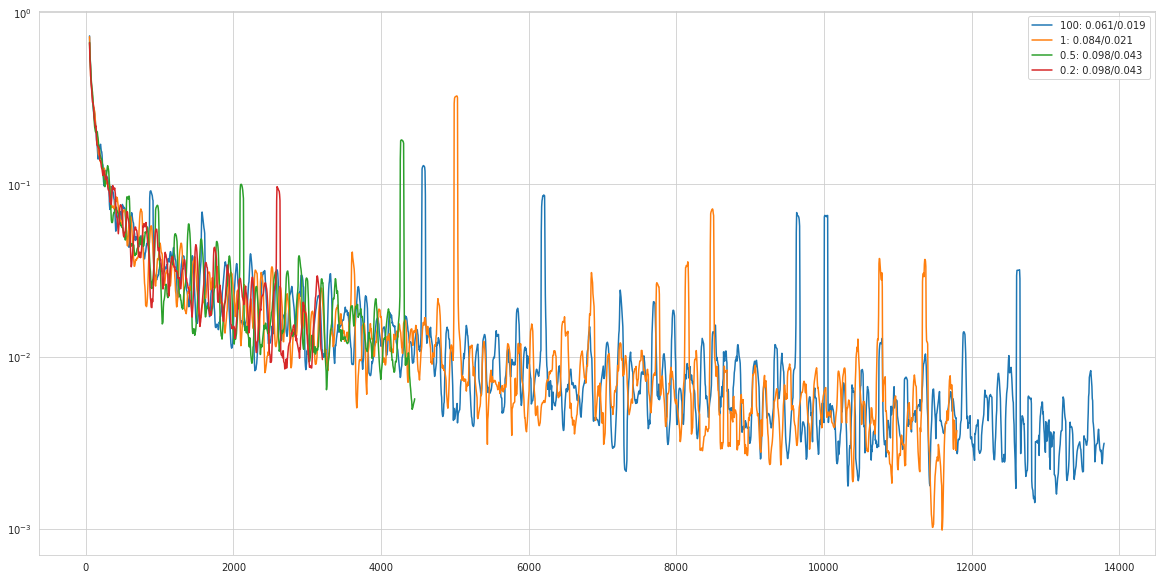

In [ ]:
rm = 10
plt.subplots(figsize=(20,10))

plt.plot(df_spec_d_010.rolling(rm).mean(), 
         label=f'100: {df_spec_d_010.std()[0]:.3f}/{df_spec_d_010.mean()[0]:.3f}');
plt.plot(df_spec_d_011.rolling(rm).mean(), 
         label=f'1: {df_spec_d_011.std()[0]:.3f}/{df_spec_d_011.mean()[0]:.3f}');
plt.plot(df_spec_d_012.rolling(rm).mean(), 
         label=f'0.5: {df_spec_d_012.std()[0]:.3f}/{df_spec_d_012.mean()[0]:.3f}');
plt.plot(df_spec_d_013.rolling(rm).mean(), 
         label=f'0.2: {df_spec_d_012.std()[0]:.3f}/{df_spec_d_012.mean()[0]:.3f}');

plt.yscale('log')
plt.legend();

In [ ]:
tag_att = 'Loss/L_att'
df_spec_att_010 = results_010[tag_att]
df_spec_att_011 = results_011[tag_att]
df_spec_att_012 = results_012[tag_att]
df_spec_att_013 = results_013[tag_att]
# df_spec_att_014 = results_014[tag_att]

tag_idt = 'Loss/L_idt'
df_spec_idt_010 = results_010[tag_idt]
df_spec_idt_011 = results_011[tag_idt]
df_spec_idt_012 = results_012[tag_idt]
df_spec_idt_013 = results_013[tag_idt]
# df_spec_idt_014 = results_014[tag_idt]

tag_rec = 'Loss/L_rec'
df_spec_rec_010 = results_010[tag_rec]
df_spec_rec_011 = results_011[tag_rec]
df_spec_rec_012 = results_012[tag_rec]
df_spec_rec_013 = results_013[tag_rec]
# df_spec_rec_014 = results_014[tag_rec]

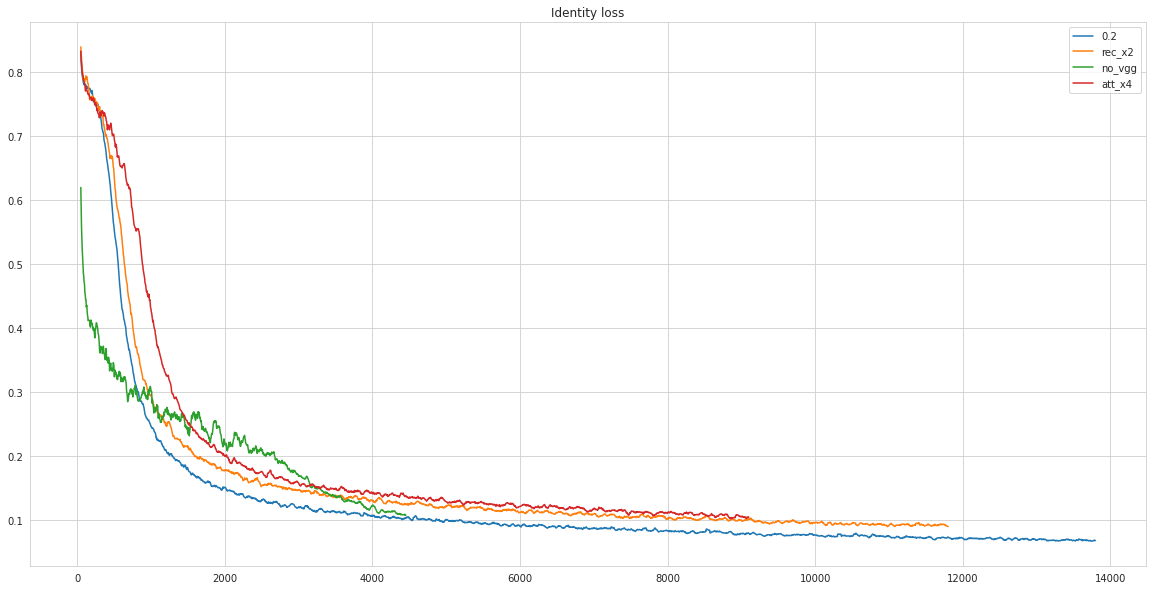

In [ ]:
plt.subplots(figsize=(20,10))
rm=10
plt.title("Identity loss")
plt.plot(df_spec_idt_010.rolling(rm).mean(), 
         label=f'0.2');
plt.plot(df_spec_idt_011.rolling(rm).mean(), 
         label=f'rec_x2');
plt.plot(df_spec_idt_012.rolling(rm).mean(), 
         label=f'no_vgg');
plt.plot(df_spec_idt_013.rolling(rm).mean(), 
         label=f'att_x4');
# plt.plot(df_spec_idt_014.rolling(rm).mean(), 
#          label=f'VGG');

plt.legend();

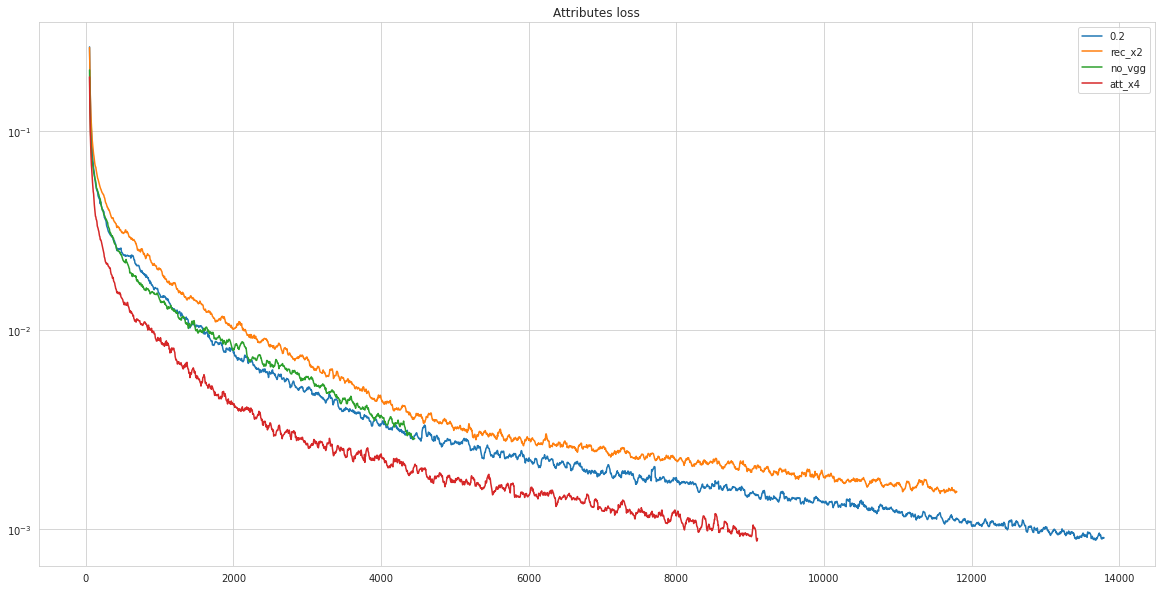

In [ ]:
plt.subplots(figsize=(20,10))
rm=10
n=1000
plt.title("Attributes loss")
plt.plot(df_spec_att_010.rolling(rm).mean(), 
         label=f'0.2');
plt.plot(df_spec_att_011.rolling(rm).mean(), 
         label=f'rec_x2');
plt.plot(df_spec_att_012.rolling(rm).mean(), 
         label=f'no_vgg');
plt.plot(df_spec_att_013.rolling(rm).mean(), 
         label=f'att_x4');
# plt.plot(df_spec_att_014.rolling(rm).mean(), 
#          label=f'VGG');
plt.yscale('log')
plt.legend();


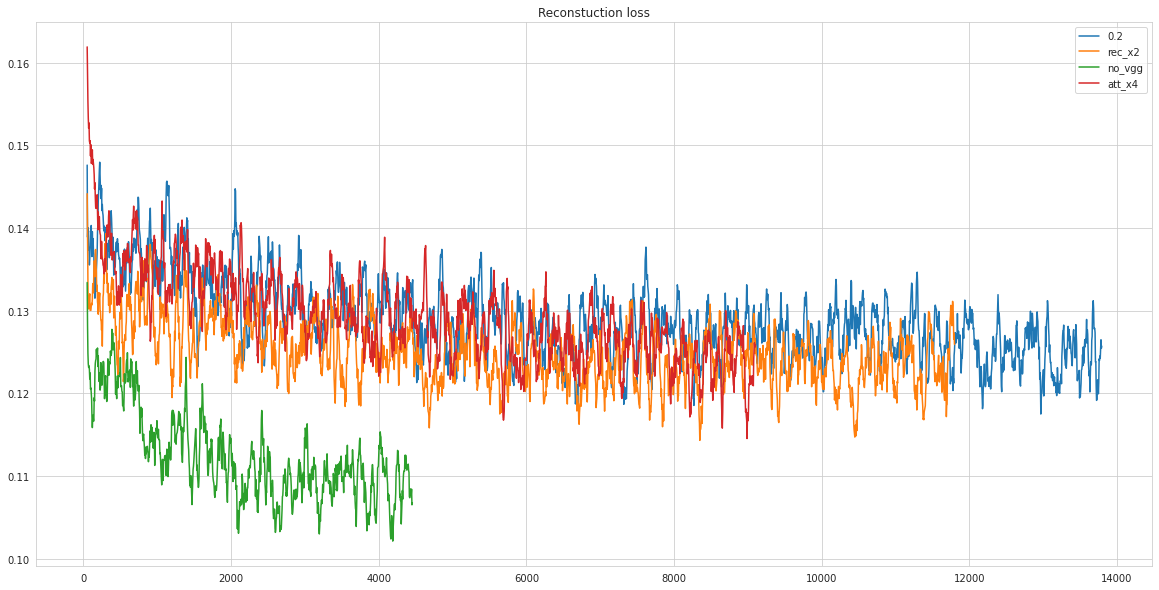

In [ ]:
plt.subplots(figsize=(20,10))
rm=10
plt.title("Reconstuction loss")
plt.plot(df_spec_rec_010.rolling(rm).mean(), 
         label=f'0.2');
plt.plot(df_spec_rec_011.rolling(rm).mean(), 
         label=f'rec_x2');
plt.plot(df_spec_rec_012.rolling(rm).mean(), 
         label=f'no_vgg');
plt.plot(df_spec_rec_013.rolling(rm).mean(), 
         label=f'att_x4');
# plt.plot(df_spec_rec_014.rolling(rm).mean(), 
#          label=f'SN_D_WGAN');
plt.legend();

### Utilize redundant image data

In [ ]:
IMG_DIR = 'info/images/'
os.listdir(IMG_DIR)

['0.0.1',
 'SN_D',
 'SN_D_G',
 'SN_D_G_TTUR',
 'SN_D_hinge',
 'SN_D_TTUR',
 'SN_D_same_prob',
 'SN_D_history',
 'SN_D_LS',
 'SN_D_NS',
 'SN_D_NS_R1',
 'SN_D_WGAN_GP',
 'SN_D_LS_vggface',
 'SN_Dx2_LS_vggface',
 'SN_D_LS_vggface_idt_x2',
 'SN_D_LS_vggface_idt_arch',
 'SN_Dx2_LS_vggface_idt_arch',
 'SN_Dx2_LS_vggface_idt_arch_2',
 'SN_D_LS_vggface_heavy',
 'SN_D_LS_vggface_heavy_idt_x100',
 'SN_D_LS_vggface_heavy_idt_x5',
 'SN_D_LS_vggface_heavy_idt_x10',
 'SN_D_LS_vggface_heavy_idt_x2',
 'SN_D_LS_vggface_heavy_idt_x1',
 'SN_D_LS_vggface_heavy_idt_x0.5',
 'SN_D_LS_vggface_heavy_idt_x0.2']

In [ ]:
import glob
test_folder = 'SN_D_LS_vggface_heavy_idt_x1/1'
pathes = glob.glob(os.path.join(IMG_DIR, test_folder, '*.jpg'))
len(pathes)

3082

In [ ]:
pathes[:10]

['info/images/SN_D_LS_vggface_heavy_idt_x1/1/img_20830.jpg',
 'info/images/SN_D_LS_vggface_heavy_idt_x1/1/img_20840.jpg',
 'info/images/SN_D_LS_vggface_heavy_idt_x1/1/img_20850.jpg',
 'info/images/SN_D_LS_vggface_heavy_idt_x1/1/img_20860.jpg',
 'info/images/SN_D_LS_vggface_heavy_idt_x1/1/img_20870.jpg',
 'info/images/SN_D_LS_vggface_heavy_idt_x1/1/img_20880.jpg',
 'info/images/SN_D_LS_vggface_heavy_idt_x1/1/img_20890.jpg',
 'info/images/SN_D_LS_vggface_heavy_idt_x1/1/img_20900.jpg',
 'info/images/SN_D_LS_vggface_heavy_idt_x1/1/img_20910.jpg',
 'info/images/SN_D_LS_vggface_heavy_idt_x1/1/img_20920.jpg']

In [ ]:

get_id = lambda p: int(re.findall(r'img_(\d+)', p)[0])
pathes_id = zip(pathes, map(get_id, pathes))
pathes_sorted = [p[0] for p in sorted(pathes_id, key=lambda x: x[1], reverse=True)]

In [ ]:
N_LEAVE = 100
pathes_delete = pathes_sorted[N_LEAVE:]
print(f"Total: {len(pathes)}\tTo delete: {len(pathes_delete)}")
_ = [os.remove(p) for p in pathes_delete]
pathes_after = glob.glob(os.path.join(IMG_DIR, test_folder, '*.jpg'))
print(f"Total: {len(pathes_after)}")
assert len(pathes_after) == N_LEAVE

Total: 3082	To delete: 2982
Total: 100


In [ ]:
from tqdm import tqdm_notebook
import re
import glob

In [ ]:
MODELS = os.listdir(IMG_DIR)[1:]
N_LEAVE = 100
get_id = lambda p: int(re.findall(r'img_(\d+)', p)[0])
bad_folders = []

for model in tqdm_notebook(MODELS, total=len(MODELS)):
  try:
    filenames = os.listdir(os.path.join(IMG_DIR,model,'1'))
  except Exception:
    bad_folders.append(model)
    continue
  pathes = [os.path.join(IMG_DIR, model, '1', f) for f in filenames]
  # pathes = glob.glob(os.path.join(IMG_DIR,model,'1','*.jpg'))
  
  if len(pathes) <= N_LEAVE:
    continue
    
  pathes_id = zip(pathes, map(get_id, pathes))
  pathes_sorted = [p[0] for p in sorted(pathes_id, key=lambda x: x[1], reverse=True)]
  pathes_delete = pathes_sorted[N_LEAVE:]

  print(f"Model: {model}\tTotal: {len(pathes)}\tTo delete: {len(pathes_delete)}")
  _ = [os.remove(p) for p in pathes_delete]
  pathes_after = glob.glob(os.path.join(IMG_DIR, model,'1', '*.jpg'))
  print(f"Total: {len(pathes_after)}")
  assert len(pathes_after) == N_LEAVE

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Model: SN_Dx2_LS_vggface	Total: 106	To delete: 6
Total: 100
Model: SN_D_LS_vggface_idt_x2	Total: 3286	To delete: 3186
Total: 100
Model: SN_D_LS_vggface_idt_arch	Total: 676	To delete: 576
Total: 100
Model: SN_Dx2_LS_vggface_idt_arch	Total: 113	To delete: 13
Total: 100
Model: SN_D_LS_vggface_heavy_idt_x100	Total: 101	To delete: 1
Total: 100
Model: SN_D_LS_vggface_heavy_idt_x10	Total: 146	To delete: 46
Total: 100
Model: SN_D_LS_vggface_heavy_idt_x0.5	Total: 2307	To delete: 2207
Total: 100
Model: SN_D_LS_vggface_heavy_idt_x0.2	Total: 106	To delete: 6
Total: 100



In [ ]:
MODELS = os.listdir(IMG_DIR)
N_LEAVE = 100
get_id = lambda p: int(re.findall(r'img_(\d+)', p)[0])
bad_folders = []

for model in tqdm_notebook(MODELS, total=len(MODELS)):
  try:
    filenames = os.listdir(os.path.join(IMG_DIR,model,'1'))
    print(f"{model}: {len(filenames)}")
  except Exception as e:
    print(f"{model}:{e}")
    bad_folders.append(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0.0.1:[Errno 2] No such file or directory: 'info/images/0.0.1/1'
Model: 100
Model: 450
Model: 100
Model: 100
Model: 100
Model: 77
Model: 100
Model: 100
Model: 100
Model: 100
Model: 100
Model: 100
Model: 106
Model: 3286
Model: 676
Model: 113
Model: 17
Model: 0
Model: 101
Model: 39
Model: 146
Model: 68
Model: 100
Model: 2307
Model: 106

